# 本地部署
MNIST是一个著名的计算机视觉数据集，其包含各种手写数字图片。通过设计一个分类模型并使用MNIST数据对其进行训练，能够得到一个用于识别输入图片中的数字的推理模型。本章将使用MNIST数据集及其手写数字图片的分类模型作为示例，编写一个本地的推理文件完成模型的推理过程。
完整的推理文件应当包括四部分：

    1. 模型定义
    2. 模型初始化与参数读取
    3. 数据处理模块
    4. 推理模块

## 模型定义
模型定义部分将给出模型的结构信息和前向传播操作，本任务采用的模型结构如下：
![](https://s3.bmp.ovh/imgs/2021/09/db5a847051fb0ae1.png)

因此，我们需要在模型的__init()__ 函数中指定模型的核心结构，如二维卷积层Conv2d，Dropout层，全连接层等。forward()函数将指定在前向传播的过程中对输入变量所进行的操作，除了在__init()__ 中给出的核心操作，我们还需要补充激活函数relu，池化层max_pool等。最后，forward()函数将返回模型的初始推理结果。

## 模型初始化与参数读取
**模型训练非本章学习重点，因此本章已提供经过预训练的模型参数文件。**

由于在PyTorch模型保存的过程中我们更加推荐保存模型参数(state_dict())而非完整的模型，因此我们需要首先将上述定义的模型初始化，再导入模型参数。**此外，我们在推理任务中需要为模型设置状态.eval()，该函数将模型中的dropout和batch normalization等操作设置为evaluation模式，防止模型在推理过程中出现问题。**

## 数据处理模块
对于手写识别任务，我们的原始输入是一张手写图片。但是对于模型来说，其输入应当是张量（tensor）。此外，许多任务在实际的学习与推理的过程中都需要首先对数据进行预处理，如本例中我们将手写图片转换为一张尺寸为28\*28的灰度图，还需要对其进行正则化以减少过拟合情况发生的可能性。此外，在推理完成后，模型的输出形态并非是我们预期的结果，如在本例中模型给出的推理结果是一个包含概率值的数组，代表每个结果的可能性，而我们希望得到的是一个确切的数字结果，所以我们需要对数组进行处理以得到最终的结果。基于上述情况，我们需要编写一个数据处理模块，其包含数据的预处理和后处理。

在本例中，数据预处理操作部署在image_to_tensor()函数负责将输入的图像转化为一个28\*28的单通道tensor（表示一个28\*28的灰度图信息），再对tensor进行正则化。
而数据后处理操作体现在run_model()函数中的model_output.detach().numpy().argmax()语句和post_process()函数。前者表示从模型给出的一系列概率值中选取最大的值作为模型的预测结果。后者则将结果从numpy类型转换为字符串类型。

## 推理模块
该模块在本例中体现为run_model()函数，其任务是执行模型推理。此外，需要注意的是，由于在推理过程中不需要更新模型参数，因此需要设置with torch.no_grad()来保证推理的过程中不再计算梯度，从而减少显存的占用。

In [ ]:
# Download Pretrained Model
!gdown --id 1omW_gpSpedWjo5GahxzksNW-J8MGrfdk --output convnet.pth

# Download Testing Image
!gdown --id 1A47zfadA6oXGhMvI-iCRj6CWB7rS8dWz --output digit_image.jpg

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from PIL import Image

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op
    
model = ConvNet()

In [ ]:
PATH_TO_MODEL = "./convnet.pth"
model.load_state_dict(torch.load(PATH_TO_MODEL, map_location="cpu")) # 导入模型参数

In [ ]:
model.eval()

In [ ]:
image = Image.open("./digit_image.jpg")

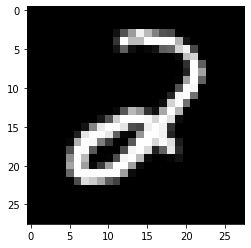

In [ ]:
image

In [ ]:
def image_to_tensor(image):
    gray_image = transforms.functional.to_grayscale(image) # 转换为灰度图
    resized_image = transforms.functional.resize(gray_image, (28, 28))
    input_image_tensor = transforms.functional.to_tensor(resized_image)
    input_image_tensor_norm = transforms.functional.normalize(input_image_tensor, (0.1302,), (0.3069,)) # 正则化
    return input_image_tensor_norm

In [ ]:
input_tensor = image_to_tensor(image)

In [ ]:
def run_model(input_tensor):
    model_input = input_tensor.unsqueeze(0)
    with torch.no_grad():
        model_output = model(model_input)[0]
    model_prediction = model_output.detach().numpy().argmax()
    return model_prediction

In [ ]:
output = run_model(input_tensor)
print(output)
print(type(output))

In [ ]:
def debug_model(input_tensor): # 输出原始的概率信息
    model_input = input_tensor.unsqueeze(0)
    with torch.no_grad():
        model_output = model(model_input)[0]
    model_prediction = model_output.detach().numpy()
    return np.exp(model_prediction)

In [ ]:
print(debug_model(input_tensor))

In [ ]:
def post_process(output):
    return str(output)

In [ ]:
final_output = post_process(output)
print(final_output)
print(type(final_output))